In [1]:
import multiprocessing
import numpy as np
from math import *
import matplotlib.pyplot as plt
from functools import partial
from scipy.interpolate import griddata
from PIL import Image
import json
from multiprocessing import Pool
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
import plotly.graph_objects as go
%matplotlib inline
import cv2

(100, 100)

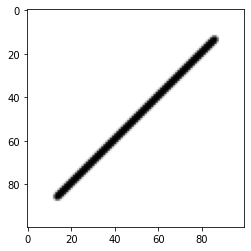

In [57]:
image = Image.open('img/linea.png')
pixel_size = 1 #reduzco complejidad
ancho, alto = image.size
nuevo_ancho = ancho // pixel_size
nuevo_alto = alto // pixel_size
imagen_pixelada = image.resize((nuevo_ancho, nuevo_alto), Image.NEAREST)
image = imagen_pixelada.convert('L')
imagen = np.array(image)
#imagen = cv2.GaussianBlur(imagen.copy(), (3,3), 0) #convoluciono por una gaussiana
#image = np.random.rand(2,2)
plt.imshow(imagen,cmap='gray')
imagen.shape

In [37]:
class GCell:
    def __init__(self):
        self.recprof = lambda posiciones : np.exp(-((posiciones[:,:,0])**2 + (posiciones[:,:,1])**2)) * np.exp(2j*(posiciones[:,:,1]))
        
def Accion(posiciones,x,y,phi):
    return np.add(np.matmul(posiciones,np.array([[cos(phi),-sin(phi)],[sin(phi),cos(phi)]])), np.array([x,y]))

def AccionInv(posiciones,x,y,phi):
    #devuelve el punto con la rotacion inversa y desplazado -
    return np.matmul((posiciones - np.array([x,y])), np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]))
    #return (posiciones - np.array([x,y])) @ np.array([[cos(phi),sin(phi)],[-sin(phi),cos(phi)]]) #no mejora el rendimiento

def O(x,y,phi,imagen,gcell,posiciones):
    #debería cambiar la suma por algo mejor? que aproxime mejor la integral
    return np.sum(imagen * (gcell.recprof(posiciones)))

class V1:
    def __init__(self, height, width, imagen):
        #inicio un tablero con las células ganglionares bajo la acción del grupo E(2), rotaciones y traslaciones en el plano
        # estaria bien hacer que no dependiera de la imagen elegida (se adapte al tamaño)
        #imagen: 
        self.n = imagen.shape[0]
        #posiciones es una discretacizacion del plano por puntos con coordenadas (i,j) habrá que crear células ganglionales con distintas posiciones
        posiciones = np.array(list(product(np.arange(1,self.n+1),repeat=2))).reshape((self.n,self.n,2))
        self.reticulo = None
        pass

def searchPhiP(x,y,imagen,gcell):
    posiciones = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2))
    #posicionesRotTrans = lambda phi : AccionInv(posiciones,x,y,phi) #rotamos y trasladamos
    
    espacioBusqueda = np.linspace(0,pi,30) #bajo los cortes, las fibras son S1 pero modulo pi
    #espacioBusqueda = np.linspace(0,2*pi,20) #bajo los cortes tomamos las fibras como S1; asi no sale
    
    #parcializo las funciones para el map
    #     aI = partial(AccionInv, posiciones, x, y)
    #     o = partial(O, x=x, y=y, imagen=imagen, gcell=gcell)
    
    acciones = np.array([AccionInv(posiciones,x,y,phi) for phi in espacioBusqueda])
    
    Os = []
    
    #Os = Parallel(n_jobs=-1)(delayed(O)(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi)) for phi in espacioBusqueda)
    #Os = np.abs(Os)
    return espacioBusqueda[np.argmax(np.fromiter([np.abs(O(x,y,phi,imagen,gcell,AccionInv(posiciones,x,y,phi))) for phi in espacioBusqueda],dtype=np.float16))]
    #return espacioBusqueda[np.argmax(np.array(Os))]

def allPhiP(imagen,gcell):
    arr = np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])
    prefdOr = {(x,y):None for x,y in arr}
    
    with ThreadPoolExecutor() as executor:
        resultados = executor.map(lambda args : searchPhiP(imagen=imagen, gcell=gcell,**{'x':args[0], 'y':args[1]}), arr)
        for res,t in zip(resultados,arr):
            prefdOr[(t[0],t[1])] = res
            
    return prefdOr

def scatterDict(datos,image,plotProyection):
    x = np.array([coord[0] for coord in datos.keys()])
    y = np.array([coord[1] for coord in datos.keys()])
    z = np.array(list(datos.values()))
    
    mycmap = 'viridis'
    
    fig = plt.figure(figsize=(20, 20))
    ax1 = fig.add_subplot(2, 2, 1)
    scatter1 = ax1.scatter(y, -x, c=z, cmap=mycmap) #invierto, si no sale al reves
    ax1.set_aspect('equal')
    ax1.set_xlabel('Eje X')
    ax1.set_ylabel('Eje Y')
    ax1.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter1, ax=ax1, label='Orientación preferida [0,pi]',fraction=0.046, pad=0.04)
    
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    if plotProyection:
        z_ = np.zeros(np.array(list(datos.values())).shape) #sirve para visualizar la proyección de los puntos
        scatter2 = ax2.scatter(x, y, z_, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    else:
        scatter2 = ax2.scatter(x, y, z, c=z, cmap=mycmap)  # El color de los puntos se basa en los valores de z
    ax2.set_xlabel('Eje X')
    ax2.set_ylabel('Eje Y')
    ax2.set_zlabel('PhiP')
    ax2.set_title('Orientación preferida para cada punto en la imagen')
    fig.colorbar(scatter2, ax=ax2, label='Altura = PhiP',fraction=0.046, pad=0.04)
    plt.tight_layout()
    
#     ax3 = fig.add_subplot(2, 2, 3)
#     x_grid, y_grid = np.meshgrid(np.linspace(min(x), max(x), 100), np.linspace(min(y), max(y), 100))
#     z_grid = griddata((x, y), z, (x_grid, y_grid), method='cubic')
#     ax3.imshow(z_grid.T, cmap=mycmap) #traspongo la matriz imagen para que este bien orientada
#     ax3.set_title('Interpolación de los puntos')
    
#     ax4 = fig.add_subplot(2, 2, 4)
#     ax4.imshow(image, cmap = 'gray')
    
    
    plt.show()
    
        
    fig2 = go.Figure(data=[go.Scatter3d(x=x, y=y, z=z, mode='markers',marker=dict(size=2,color=z, colorscale='Viridis'))])
    fig2.update_layout(scene=dict(
                        xaxis_title='X Label',
                        yaxis_title='Y Label',
                        zaxis_title='Altura preferida'))

    fig2.show()

In [5]:
gcell = GCell()
%time mydict = allPhiP(imagen,gcell)

CPU times: total: 9min 38s
Wall time: 5min


from IPython.display import display, Javascript
display(Javascript('alert("La ejecución de la celda ha finalizado.")'))

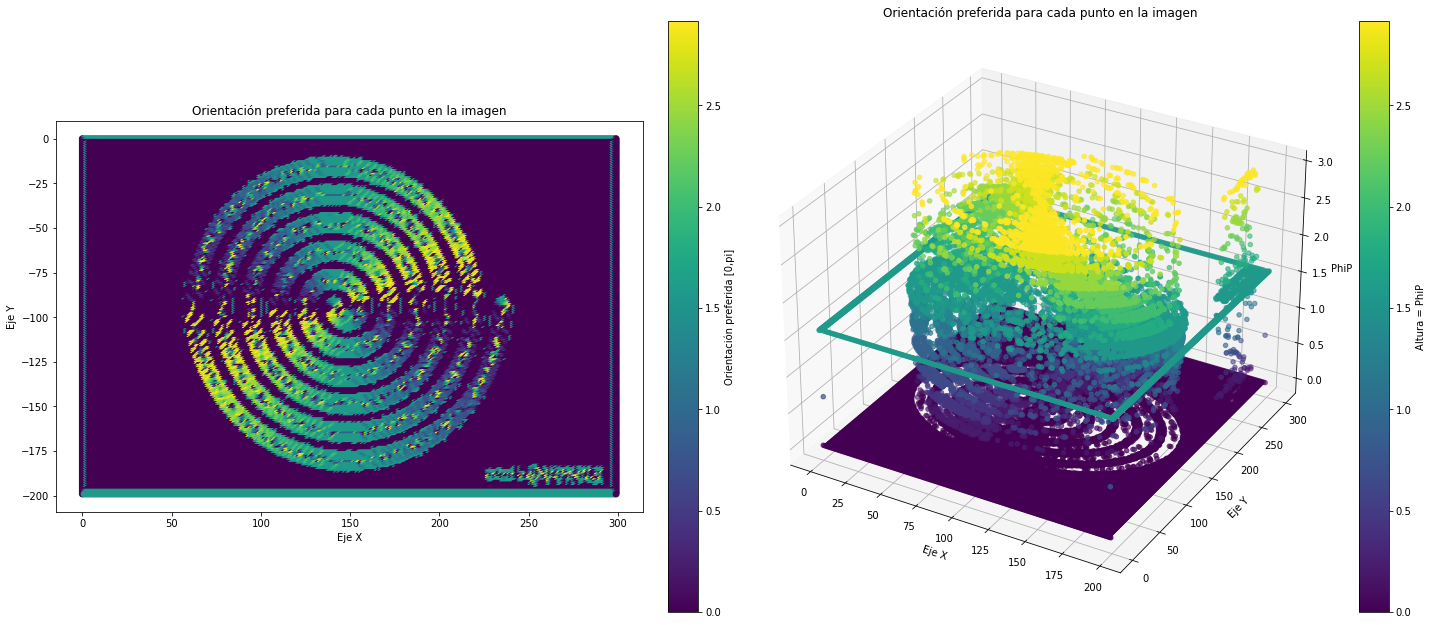

In [45]:
scatterDict(mydict,imagen,False)

with open('circle.json', 'w') as file:
    json.dump({str(k): v for k, v in mydict.items()}, file, indent=4)

In [44]:
with open('safeCalcs/espiraldata.json') as file:
    aux = json.load(file)
mydict2 = {eval(k):v for k,v in aux.items()}
mydict = mydict2

# ''Limpio'' el fibrado con los contornos

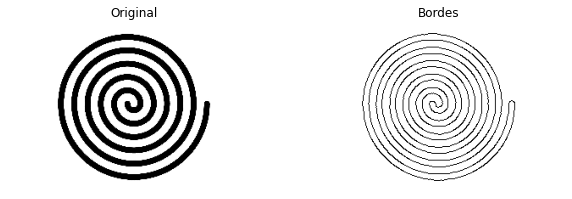

In [48]:
#saco los puntos que perteneces al borde
import cv2

bordes = cv2.Canny(imagen.copy(), 50, 150)

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(imagen, cmap='gray')
plt.title('Original')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(bordes, cmap='binary')
plt.title('Bordes')
plt.axis('off')

plt.show()

# Elevación de curvas al fibrado (discretizado)

Voy a intentar elevar las curvas al fibrado

Problemas:
   
- 1 Los puntos del contorno en la variable bordes NO esta ordenado, en el sentido que, los puntos del borde sí están representados, pero no están ordenados ``linealmente'' como para poder hacer interpolación directa de los puntos a partir de la matriz.

In [49]:
def plot_in_fibration(mydict, imagen, addLines, addPoints, addInitial):
    
    #Hago la convolución con una gaussiana
    gaussifyed_image = cv2.GaussianBlur(imagen.copy(), (3,3), 0)
    
    # obtengo los puntos de la curva (bordes), en forma de indexado de puntos pixeles (x,y)
    bordes = cv2.Canny(imagen.copy(), 50, 150)
    
    #extraemos contornos (nos devuelve un orden apropiado para hacer el plot go)
    (contornos, _) = cv2.findContours(bordes.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    #conts = cv2.drawContours(imagen.copy(),contornos,-1,(0,0,255), 2)

    fig = go.Figure(layout=dict(width=1000, height=1000))
    
    if addLines:
        for contorno in contornos:
            #cuando hacemos el findcontours puede haber varias componentes conexas
            contorno = contorno.reshape((contorno.shape[0],2))
            xe = contorno[:,1] #invierte las componentes
            ye = contorno[:,0]
            z = np.array([mydict[(i[1],i[0])] for i in contorno]) #invierte las componentes
            fig.add_trace(go.Scatter3d(x=xe, y=ye, z=z, marker=dict(size=1,color=z,colorscale='Viridis'), line=dict(color=z,colorscale='Viridis', width=2)))

    
    #creo una matriz con todos los índices apuntando a pixeles de la imagen de los bordes
    indices_bordes = np.argwhere(np.ones_like(bordes)).reshape((*np.ones_like(bordes).shape,2))

    #tengo que hacer reshape a lo anterior para que sea una de tamaño 100,2
    indices_bordes = indices_bordes.reshape(-1, *np.argwhere(np.ones_like(imagen)).reshape((*np.ones_like(imagen).shape,2)).shape[2:])

    # ya tengo los índices de los puntos del borde de la imagen, ahora busco en mi diccionario mydict, y los subo al fibrado (creando otro diccionario)
    dic_bordes_fibrado = {(k[0],k[1]): mydict[(k[0],k[1])] if (bordes[(k[0],k[1])] == 255) else 0 for k in indices_bordes}

    #saco los puntos(indices) que pertenecen a un borde
    puntos_bordes_altura = {k:v for k,v in dic_bordes_fibrado.items() if dic_bordes_fibrado[k] != 0} #me quedo con los items quetengan altura
    puntos_cv = np.array([i for i in dic_bordes_fibrado.keys() if bordes[i[0],i[1]]!=0]) #puntos reales del borde 2D


    #saco los puntos 2D y la altura z
    puntos_bordes_2D = np.array(list(puntos_bordes_altura.keys()))
    z = np.array(list(puntos_bordes_altura.values()))

    #separo los x e y de puntos_bordes_2D
    x,y = puntos_bordes_2D[:,0], puntos_bordes_2D[:,1]
    
    if addPoints:
        fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(size=1.5,color=z,colorscale='Viridis'), name='Datos originales'))
    
    if addInitial:
        fig.add_trace(go.Scatter3d(x=puntos_cv[:,0].ravel(), y=puntos_cv[:,1].ravel(), z=np.zeros(puntos_cv[:,1].ravel().size), mode='markers', marker=dict(size=1.5,color='red',), name='Original'))

    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Altura Preferida'))
    fig.show()

In [53]:
plot_in_fibration(mydict,imagen,True,True,True)